In [1]:
"""
Notes:
- GarageType variable might be biased. Note that it has a 2types variable making our dummy variables technically incorrect since we dont know which 2 types it is
- PavedDrive: It could be argued that this variable should be numerically categorized rather than turned into dummy variables
"""

'\nNotes:\n- GarageType variable might be biased. Note that it has a 2types variable making our dummy variables technically incorrect since we dont know which 2 types it is\n- PavedDrive: It could be argued that this variable should be numerically categorized rather than turned into dummy variables\n'

In [2]:
import numpy as np
import pandas as pd

import os
# Matplotlib for visualization
from matplotlib import pyplot as plt


# Seaborn for easier visualization
import seaborn as sns

from scipy import stats
sns.set()

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
#warnings.filterwarnings("ignore")

In [3]:
# SET ENV VARIABLES
train_csv = 'train.csv'
test_csv = 'test.csv'

In [4]:
# Read CSV
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

In [5]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [6]:
print(train_df.dtypes)

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object


# Data Cleaning

Skweness is a measure of symmetry or lack of symmetry.
A distribution is symmetric if it looks the same to the left and right of the center point.
Kurtosis is a measure whether the data are heavily-tailed or light-tailed relative to the normal distribution.

It is very difficult to interpret and analyze the data which is skewed. Likewise, a collection of data points that are normally distributed (symmetrical) or nearer to symmetrical are easier for computation and more probable for producing better inferences. Hence, reducing the skewness becomes an important part of the data cleaning process for data scientists.

Skewness: 1.882876
Kurtosis: 6.536282


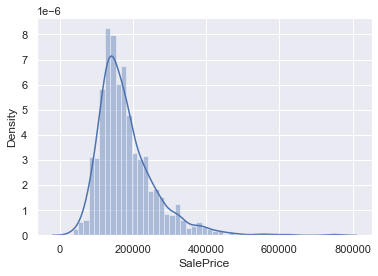

In [7]:
sns.distplot(train_df['SalePrice']);
#skewness and kurtosis
print("Skewness: %f" % train_df['SalePrice'].skew())
print("Kurtosis: %f" % train_df['SalePrice'].kurt())

The variable SalePrice is not normally distributed. This can reduce the accuracy of our ML models since most of them assume a Guassian distribution.

Therfore we make a log transformation, the resulting distribution looks much better.

Skewness: 0.121347
Kurtosis: 0.809519


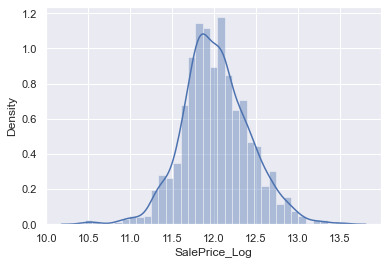

In [8]:
train_df['SalePrice_Log'] = np.log1p(train_df['SalePrice'])

sns.distplot(train_df['SalePrice_Log']);
# skewness and kurtosis
print("Skewness: %f" % train_df['SalePrice_Log'].skew())
print("Kurtosis: %f" % train_df['SalePrice_Log'].kurt())

In [9]:
train_df.shape
test_df.shape

(1459, 80)

### Numerical features vs categorial features

In [10]:
numerical_feats = train_df.dtypes[train_df.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train_df.dtypes[train_df.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  39
Number of Categorical features:  43


In [11]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageQual,81,0.055479


# Data Preprocessing

Filling missing values For a few columns there is lots of NaN entries. However, reading the data description we find this is not missing data: For PoolQC, NaN is not missing data but means no pool, likewise for Fence, FireplaceQu etc.

First we get rid of NA or nan values in numerical columns and use its average. We convert categorical columns to numerical columns as 1-hot vectors to get a better understanding of which categories contribute to a more expensive or less expensive houses.

In [12]:
class HousePreprocessor():
    def __init__(self, verbose=True):
        self.verbose = verbose
        # Cnvrt disp Vars
        self.disp_cats = [('Electrical', 'SBrkr'), ('BsmtFinType2', 'Unf')]
        
        # Cnvrt Relative Vars
        rating_order_map = {
            'Po': 0,
            'Fa': 1,
            'TA': 2,
            'Gd': 3,
            'Ex': 4,
            'NA': 'NA',
            np.nan: 'NA'
        }

        basement_exposure_map = {
            'No': 0,
            'Mn': 1,
            'Av': 2,
            'Gd': 3,
            'NA': 'NA',
            np.nan: 'NA'
        }

        basement_finish_map = {
            'Unf': 0,
            'LwQ': 1,
            'Rec': 2,
            'BLQ': 3,
            'ALQ': 4,
            'GLQ': 5,
            'NA': 'NA',
            np.nan: 'NA'
        }

        functional_rating = {
            'Sal': 0,
            'Sev': 1,
            'Maj2': 2,
            'Maj1': 3,
            'Mod': 4,
            'Min2': 5,
            'Min1': 6,
            'Typ': 7,
            'NA': 'NA',
            np.nan: 'NA'
        }

        garage_finish_rating = {
            'Unf': 0,
            'RFn': 1,
            'Fin': 2,
            'NA': 'NA',
            np.nan: 'NA'
        }

        fence_quality_rating = {
            "MnWw": 0,
            "GdWo": 1,
            "MnPrv": 2,
            "GdPrv": 3,
            "NA": "NA",
            np.nan: 'NA'
        }

        bool_map = {
            'N': 0,
            'Y': 1
        }

        self.relative_categories = (
            [(cat, rating_order_map) for cat in ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']] + 
            [(cat, basement_exposure_map) for cat in ['BsmtExposure']] +
            [(cat, basement_finish_map) for cat in ['BsmtFinType1']] +
            [(cat, functional_rating) for cat in ['Functional']] +
            [(cat, garage_finish_rating) for cat in ['GarageFinish']] +
            [(cat, fence_quality_rating) for cat in ['Fence']] +
            [(cat, bool_map) for cat in ['CentralAir']]
        )
        
        # Cyclical Vars
        self.cyclical_features = ['MoSold']

        # Dummy Vars
        self.dummy_vars_to_append = ['MSSubClass']
        
    def process(self, df):
        df = self.__cnvrt_disp_class_vars__(df)
        df = self.__cnvrt_relative_cats__(df)
        df = self.__cnvrt_cyclical_vars__(df)
        
        self.__log_remaining_category_vars__(df)
        
        df =  self.__add_dummy_vars__(df)
        
        df = self.__cnvrt_na_to_avg__(df)
        
        return df
    
    def __cnvrt_disp_class_vars__(self, df):
        # Convert Disproportionate Classification Variables
        """
        NOTE: The electrical variable is disproportionately SBrkr. As a result, we will convert Electrical to a boolean of SBrkr vs Not SBrkr rather than creating more variables

        SBrkr - 1334 (91.5%)
        FuseA - 1    (0.05%)
        FuseF - 94   (6.5%)
        FuseP - 27   (1.8%)
        Mix   - 3    (0.25%)

        NOTE: The electrical variable is disproportionately SBrkr. As a result, we will convert Electrical to a boolean of SBrkr vs Not SBrkr rather than creating more variables

        GLQ - 14
        ALQ - 19
        BLQ - 33
        Rec - 54
        LwQ - 46
        Unf - 1256
        NA - 38


        Note: An argument could be made to do the same for BsmtExposure, though we have decided against converting it into a boolean variable

        GD - 134
        Av - 221
        Mn - 114
        No - 953
        NA - 38

        """       
        for cat, key in self.disp_cats:
            df[cat] = [1 if e == key else 0 for e in df[cat]]
            
        return df
            
    def __cnvrt_relative_cats__(self, df):
        # Convert Relative Categorical into numerical
        for cat, map in self.relative_categories:
            num_na = len([i for i in df[cat] if i is np.nan])
            df[cat] = [map[rating] for rating in df[cat]]
            cat_na = f'{cat}_NA'

            # Create Boolean NA Column
            df[cat_na] = [1 if v == 'NA' else 0 for v in df[cat]]

            assert(num_na == sum(df[cat_na]))

            # Convert NA to average (IS THIS REALLY THE BEST STRATEGY?)
            avg = np.average([i for i in df[cat] if i != 'NA'])
            df[cat] = [i if i != 'NA' else avg for i in df[cat]]
        return df
            
    def __cnvrt_cyclical_vars__(self, df):
        # Convert to cyclical (See for more information)
        for f in self.cyclical_features:
            df[f'{f}_sin'] = np.sin(df[f])
            df[f'{f}_cos'] = np.cos(df[f])
            df.drop(f, 1)
            
        return df
            
    def __log_remaining_category_vars__(self, df):
        if self.verbose:
            # Decide which categorical variables you want to use
            # TODO: Convert to bar chart
            for col_name in df.columns:
                if df[col_name].dtypes == 'object':
                    unique_cat = len(df[col_name].unique())
                    print(f'Feature {col_name} has {unique_cat} unique categories')
            
    def __add_dummy_vars__(self, df):           
        dummy_list = [col for col in df.columns if df[col].dtypes == 'object']
        dummy_list = dummy_list + self.dummy_vars_to_append
        
        for cat in dummy_list:
            dummies = pd.get_dummies(df[cat], prefix=cat, dummy_na=True)
            df = df.drop(cat, 1)
            df = pd.concat([df, dummies], axis=1)
            
        return df
    
    def __cnvrt_na_to_avg__(self, df):
        # NOTE: Since Garage YR blt has NA values, we have decided to deal with this by using the average year as the NA value 
        # (IS THIS REALLY THE BEST STRATEGY?)
        cols_with_na = df.isnull().sum().sort_values(ascending=False)
        cols_with_na = list(cols_with_na[cols_with_na > 0].keys())
        
        for col in cols_with_na:
            if self.verbose:
                print(f"Converting nan's in {col} to avg of {col}")
            
            avg = np.average([i for i in df[col] if not np.isnan(i)])
            df[col] = [avg if np.isnan(i) else i for i in df[col]]
        
        cols_with_na = df.isnull().sum().sort_values(ascending=False)
        cols_with_na = cols_with_na[cols_with_na > 0]
        assert 0 == cols_with_na.shape[0]
        
        return df       
        

In [13]:
hp = HousePreprocessor()
train_df = hp.process(train_df)
print("-------------------------")
test_df = hp.process(test_df)

Feature MSZoning has 5 unique categories
Feature Street has 2 unique categories
Feature Alley has 3 unique categories
Feature LotShape has 4 unique categories
Feature LandContour has 4 unique categories
Feature Utilities has 2 unique categories
Feature LotConfig has 5 unique categories
Feature LandSlope has 3 unique categories
Feature Neighborhood has 25 unique categories
Feature Condition1 has 9 unique categories
Feature Condition2 has 8 unique categories
Feature BldgType has 5 unique categories
Feature HouseStyle has 8 unique categories
Feature RoofStyle has 6 unique categories
Feature RoofMatl has 8 unique categories
Feature Exterior1st has 15 unique categories
Feature Exterior2nd has 16 unique categories
Feature MasVnrType has 5 unique categories
Feature Foundation has 6 unique categories
Feature Heating has 6 unique categories
Feature GarageType has 7 unique categories
Feature PavedDrive has 3 unique categories
Feature MiscFeature has 5 unique categories
Feature SaleType has 9 uni

Make sure we get rid of null and nan values

In [14]:
train_df.isnull().sum().sum()

0

In [15]:
numerical_feats = train_df.dtypes[train_df.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train_df.dtypes[train_df.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  286
Number of Categorical features:  0


Data Analysis

Skewness: 1.882876
Kurtosis: 6.536282


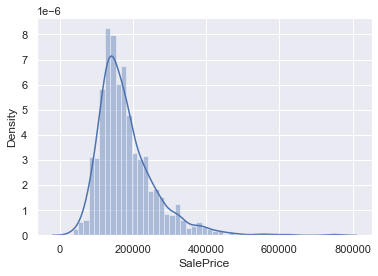

In [16]:
sns.distplot(train_df['SalePrice']);
#skewness and kurtosis
print("Skewness: %f" % train_df['SalePrice'].skew())
print("Kurtosis: %f" % train_df['SalePrice'].kurt())

The variable SalePrice is not normally distributed. This can reduce the accuracy of our ML models since most of them assume a Guassian distribution.
Therfore we make a log transformation, the resulting distribution looks much better.

Skewness: 0.121347
Kurtosis: 0.809519


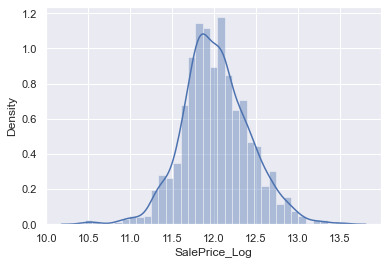

In [17]:
train_df['SalePrice_Log'] = np.log1p(train_df['SalePrice'])

sns.distplot(train_df['SalePrice_Log']);
# skewness and kurtosis
print("Skewness: %f" % train_df['SalePrice_Log'].skew())
print("Kurtosis: %f" % train_df['SalePrice_Log'].kurt())

In [18]:
for col in numerical_feats:
    print(col)
    print("Skewness: %f" % train_df[col].skew())
    print("Kurtosis: %f" % train_df[col].kurt())
    print("*"*50)

Id
Skewness: 0.000000
Kurtosis: -1.200000
**************************************************
LotFrontage
Skewness: 2.384950
Kurtosis: 21.848165
**************************************************
LotArea
Skewness: 12.207688
Kurtosis: 203.243271
**************************************************
OverallQual
Skewness: 0.216944
Kurtosis: 0.096293
**************************************************
OverallCond
Skewness: 0.693067
Kurtosis: 1.106413
**************************************************
YearBuilt
Skewness: -0.613461
Kurtosis: -0.439552
**************************************************
YearRemodAdd
Skewness: -0.503562
Kurtosis: -1.272245
**************************************************
MasVnrArea
Skewness: 2.676412
Kurtosis: 10.154316
**************************************************
ExterQual
Skewness: 0.825988
Kurtosis: 0.060816
**************************************************
ExterCond
Skewness: 1.397219
Kurtosis: 6.100074
**************************************************

Skewness: 0.000000
Kurtosis: 0.000000
**************************************************
Heating_Floor
Skewness: 38.209946
Kurtosis: 1460.000000
**************************************************
Heating_GasA
Skewness: -6.537217
Kurtosis: 40.791077
**************************************************
Heating_GasW
Skewness: 8.847848
Kurtosis: 76.389056
**************************************************
Heating_Grav
Skewness: 14.352680
Kurtosis: 204.279269
**************************************************
Heating_OthW
Skewness: 26.990701
Kurtosis: 727.494510
**************************************************
Heating_Wall
Skewness: 19.045943
Kurtosis: 361.242801
**************************************************
Heating_nan
Skewness: 0.000000
Kurtosis: 0.000000
**************************************************
GarageType_2Types
Skewness: 15.518770
Kurtosis: 239.159822
**************************************************
GarageType_Attchd
Skewness: -0.391218
Kurtosis: -1.849484
*************

Skewness: 1.366560
Kurtosis: 4.895121


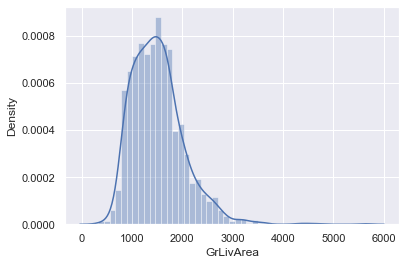

In [19]:
sns.distplot(train_df['GrLivArea']);
#skewness and kurtosis
print("Skewness: %f" % train_df['GrLivArea'].skew())
print("Kurtosis: %f" % train_df['GrLivArea'].kurt())

Skewness: 12.207688
Kurtosis: 203.243271


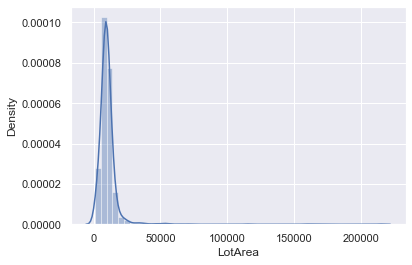

In [20]:
sns.distplot(train_df['LotArea']);
#skewness and kurtosis
print("Skewness: %f" % train_df['LotArea'].skew())
print("Kurtosis: %f" % train_df['LotArea'].kurt())

Fixing skewness and kurtosis in GrLivArea and LotArea_Log

In [21]:
for df in [train_df, test_df]:
    df['GrLivArea_Log'] = np.log(df['GrLivArea'])
    df.drop('GrLivArea', inplace= True, axis = 1)
    df['LotArea_Log'] = np.log(df['LotArea'])
    df.drop('LotArea', inplace= True, axis = 1)
    
numerical_feats = train_df.dtypes[train_df.dtypes != "object"].index

Skewness: -0.006995
Kurtosis: 0.282603


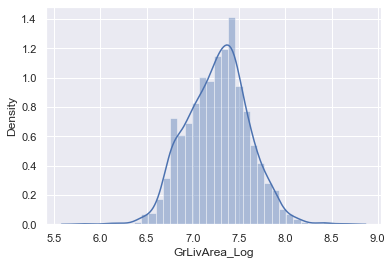

In [22]:
sns.distplot(train_df['GrLivArea_Log']);
#skewness and kurtosis
print("Skewness: %f" % train_df['GrLivArea_Log'].skew())
print("Kurtosis: %f" % train_df['GrLivArea_Log'].kurt())

Skewness: -0.137994
Kurtosis: 4.713358


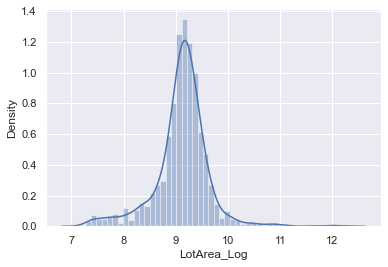

In [23]:
sns.distplot(train_df['LotArea_Log']);
#skewness and kurtosis
print("Skewness: %f" % train_df['LotArea_Log'].skew())
print("Kurtosis: %f" % train_df['LotArea_Log'].kurt())

# Relation of features to target (SalePrice_log) using seaborn.regplot

sns.regplot function allow us to plot the relationship between two variables in a DataFrame which give us an idea about the relationship between all data points of a feature/column versus the SalePrice_log

seaborn.regplot(x, y, axes to draw the plot, color)

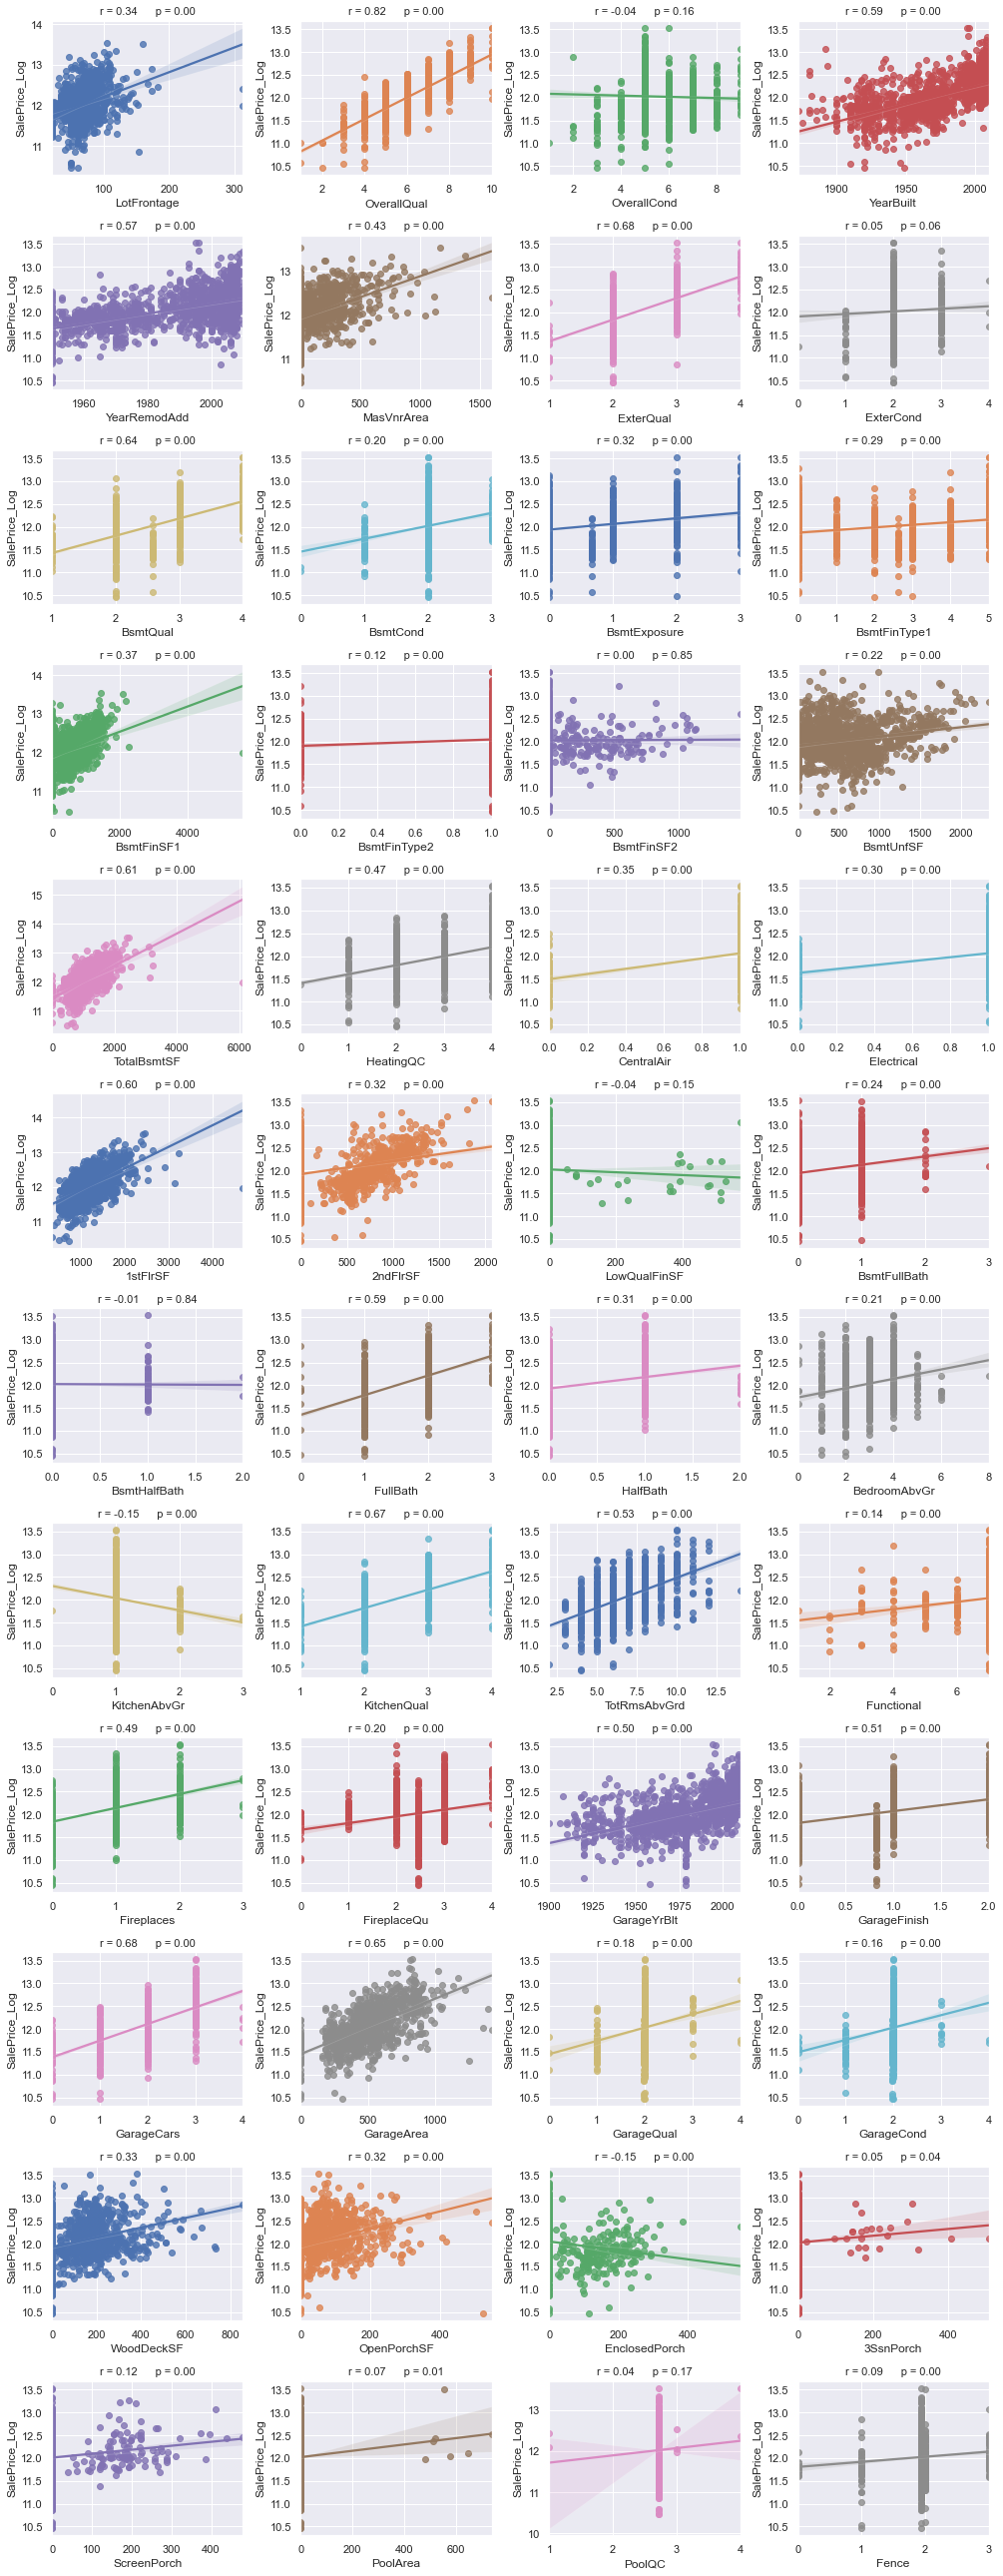

In [24]:
nr_rows = 12
nr_cols = 4
target = 'SalePrice_Log'
colors = sns.color_palette()

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

li_num_feats = list(numerical_feats)
li_not_plot = ['Id', 'SalePrice', 'SalePrice_Log']
li_plot_num_feats = [c for c in list(numerical_feats) if c not in li_not_plot]


for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_plot_num_feats):
            sns.regplot(train_df[li_plot_num_feats[i]], train_df[target], ax = axs[r][c], color=colors[i % 10])
            stp = stats.pearsonr(train_df[li_plot_num_feats[i]], train_df[target])

            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
plt.show()

### Correlation

Measuring correlation between two features it is considered a very important step in feature selection since it helps us to predict one attribute from another (dependent vectors) and it can indicate the presence of a casual relationship.

A dataset with small correlation ratios have a high change that Logistic Regression or Linear Regression models might be impacted by Multicollinearity which happens when one predictor variable in a multiple regression model can be linearly predicted from the others with a high degree of accuracy.

Fortunately, Pandas framework include a function DataFrame.corr(method='pearson', min_periods=1) to compute pairwise correlation of columns.

In [25]:
min_val_corr = 0.6

corr = train_df.corr()
corr_abs = corr.abs()

nr_num_cols = len(numerical_feats)
ser_corr = corr_abs.nlargest(nr_num_cols, target)[target]

cols_abv_corr_limit = list(ser_corr[ser_corr.values > min_val_corr].index)
cols_bel_corr_limit = list(ser_corr[ser_corr.values <= min_val_corr].index)

In [26]:
print(ser_corr)
print("*"*30)
print("List of numerical features with r above min_val_corr :")
print(cols_abv_corr_limit)
print("*"*30)
print("List of numerical features with r below min_val_corr :")
print(cols_bel_corr_limit)

SalePrice_Log       1.000000
SalePrice           0.948374
OverallQual         0.817185
GrLivArea_Log       0.730255
GarageCars          0.680625
                      ...   
SaleType_ConLI      0.003058
RoofMatl_ClyTile    0.002696
MoSold_cos          0.001770
MiscFeature_Gar2    0.001624
MSSubClass_80.0     0.001134
Name: SalePrice_Log, Length: 258, dtype: float64
******************************
List of numerical features with r above min_val_corr :
['SalePrice_Log', 'SalePrice', 'OverallQual', 'GrLivArea_Log', 'GarageCars', 'ExterQual', 'KitchenQual', 'GarageArea', 'BsmtQual', 'TotalBsmtSF']
******************************
List of numerical features with r below min_val_corr :
['1stFlrSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'TotRmsAbvGrd', 'Foundation_PConc', 'GarageFinish', 'FireplaceQu_NA', 'GarageYrBlt', 'Fireplaces', 'HeatingQC', 'MasVnrArea', 'GarageType_Attchd', 'MSSubClass_60.0', 'LotArea_Log', 'MasVnrType_None', 'GarageType_Detchd', 'BsmtFinSF1', 'Neighborhood_NridgHt', '

In [27]:
def plot_corr_matrix(df, nr_c, targ) :
    
    corr = df.corr()
    corr_abs = corr.abs()
    cols = corr_abs.nlargest(nr_c, targ)[targ].index
    cm = np.corrcoef(df[cols].values.T)

    plt.figure(figsize=(nr_c/1.5, nr_c/1.5))
    sns.set(font_scale=1.25)
    sns.heatmap(cm, linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, 
                yticklabels=cols.values, xticklabels=cols.values
               )
    plt.show()

In [28]:
nr_feats = len(cols_abv_corr_limit)

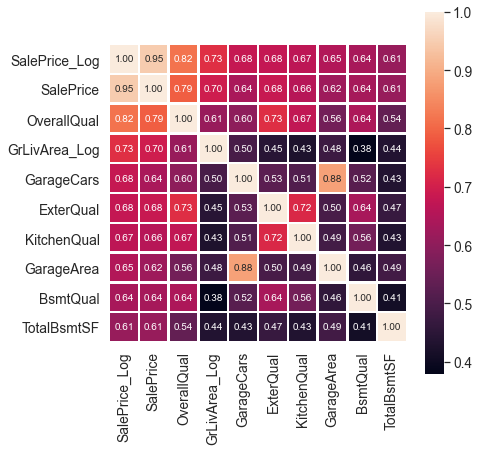

In [29]:
plot_corr_matrix(train_df, nr_feats, target)

Conclusion from EDA on numerical columns:

We see that for some features like 'OverallQual' there is a strong linear correlation (0.81) to the target. For other features like 'MSSubClass' or 'MiscFeature' the correlation is very weak. For this kernel I decided to use only those features for prediction that have a correlation larger than a threshold value to SalePrice. This threshold value can be choosen in the global settings : min_val_corr

With the default threshold for min_val_corr = 0.6, these features are dropped in Data Wrangling:

In [30]:
print(cols_bel_corr_limit)

['1stFlrSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'TotRmsAbvGrd', 'Foundation_PConc', 'GarageFinish', 'FireplaceQu_NA', 'GarageYrBlt', 'Fireplaces', 'HeatingQC', 'MasVnrArea', 'GarageType_Attchd', 'MSSubClass_60.0', 'LotArea_Log', 'MasVnrType_None', 'GarageType_Detchd', 'BsmtFinSF1', 'Neighborhood_NridgHt', 'CentralAir', 'MSZoning_RM', 'Foundation_CBlock', 'Exterior2nd_VinylSd', 'LotFrontage', 'Exterior1st_VinylSd', 'WoodDeckSF', 'MSSubClass_30.0', 'SaleType_New', 'SaleCondition_Partial', 'GarageFinish_NA', 'GarageType_nan', 'GarageCond_NA', 'GarageQual_NA', 'OpenPorchSF', '2ndFlrSF', 'BsmtExposure', 'HalfBath', 'MasVnrType_Stone', 'Electrical', 'PavedDrive_Y', 'MSZoning_RL', 'BsmtFinType1', 'LotShape_Reg', 'PavedDrive_N', 'Neighborhood_NoRidge', 'HouseStyle_2Story', 'Foundation_BrkTil', 'LotShape_IR1', 'BsmtFullBath', 'Neighborhood_IDOTRR', 'Neighborhood_OldTown', 'MasVnrType_BrkFace', 'GarageType_BuiltIn', 'BsmtUnfSF', 'Neighborhood_Edwards', 'SaleType_WD', 'BedroomAbvGr', 'BsmtC

### TSNE, PCA and k-Means

TSNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. It is recommended to use a dimensionality reduction method like PCA to reduce the number of dimensions to a reasonable amount to plot. Finally KMeans algorithm will help us to split our PCA components into five clusters according to the target (Sale Price).

0.22715934930650275


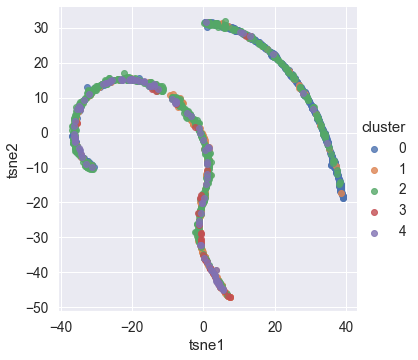

In [31]:
# StandardScaler from Scikit-Learn
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

features = [f for f in train_df.columns]
model = TSNE(n_components=2, random_state=0, perplexity=50)
X = train_df[features].fillna(0.).values
tsne = model.fit_transform(X)

std = StandardScaler()
s = std.fit_transform(X)
pca = PCA(n_components=8)
pca.fit(s)
pc = pca.transform(s)
kmeans = KMeans(n_clusters=5)
kmeans.fit(pc)

fr = pd.DataFrame({'tsne1': tsne[:,0], 'tsne2': tsne[:, 1], 'cluster': kmeans.labels_})
sns.lmplot(data=fr, x='tsne1', y='tsne2', hue='cluster', fit_reg=False)
print(np.sum(pca.explained_variance_ratio_))

First 8 PCA Components explain 22% of variance. There seems to be some clustering present but it is not enough for representing most data information.

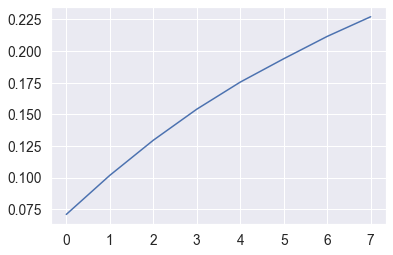

In [32]:
import numpy as np
# Matplotlib for visualization
from matplotlib import pyplot as plt
# display plots in the notebook
%matplotlib inline 

# Cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.plot(range(len(cumulative_explained_variance)), cumulative_explained_variance)

# Data Wrangling

Now lets try drop categories with weak correlation to SalePrice

In [33]:
train_df_less_weak_cat = train_df.copy()
test_df_less_weak_cat = test_df.copy()
for df in [train_df_less_weak_cat]:
    df.drop(cols_bel_corr_limit, inplace= True, axis = 1)

0.9842943637939536


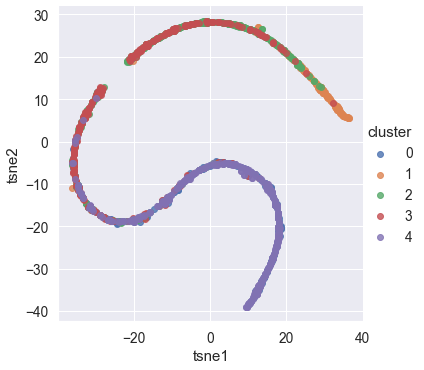

In [34]:
features = [f for f in train_df_less_weak_cat.columns]
model = TSNE(n_components=2, random_state=0, perplexity=50)
X = train_df_less_weak_cat[features].fillna(0.).values
tsne = model.fit_transform(X)

std = StandardScaler()
s = std.fit_transform(X)
pca = PCA(n_components=8)
pca.fit(s)
pc = pca.transform(s)
kmeans = KMeans(n_clusters=5)
kmeans.fit(pc)

fr = pd.DataFrame({'tsne1': tsne[:,0], 'tsne2': tsne[:, 1], 'cluster': kmeans.labels_})
sns.lmplot(data=fr, x='tsne1', y='tsne2', hue='cluster', fit_reg=False)
print(np.sum(pca.explained_variance_ratio_))

After dropping weakly correlated categories our 8 PCA Components explain 98% of variance.

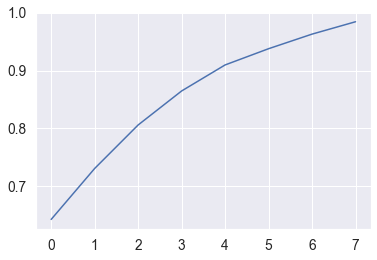

In [35]:
import numpy as np
# Matplotlib for visualization
from matplotlib import pyplot as plt
# display plots in the notebook
%matplotlib inline 

# Cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.plot(range(len(cumulative_explained_variance)), cumulative_explained_variance)

In [36]:
# Display explained variance ratio
pca.explained_variance_ratio_

array([0.64292724, 0.08796183, 0.07512266, 0.05872682, 0.04495904,
       0.02802474, 0.02520401, 0.021368  ])